In [1]:
#User inputs
import os.path

#project locations (shapefile with location of elements to evaluate)
#data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#data_folder=os.path.join(os.pardir,'dataset')
#project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
#project_id='Name' #name of column used as id

#study boundary (optional)
#study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')

#study boundary (optional)
#study_area_path=os.path.join(data_folder,'timor/boundaries.shp')
#area_sq=os.path.join(data_folder,'timor/timor_.shp')
#output folder
#out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Scripts\outputs'
#out_path_database=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#projection CRS (default = 'EPSG:4326')
#bCRS='EPSG:4326'

#buffer for climate/grid variables
#buffer=10000 #buffer in meters, 0 = no buffer is computed

#mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)

In [2]:
#Import python packages
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray #used when calling ncdata.rio.write_crs
import xarray as xr
import os
import os.path
import matplotlib.pyplot as plt
import netCDF4 as nc#not directly used but needs to be imported for some nc4 files manipulations, use for nc files
from netCDF4 import Dataset
import csv #REMOVE ? not in use ?
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import shutil # to move folders
import warnings
warnings.filterwarnings('ignore') # to ignore the warnings
#import io
import cdsapi # for copernicus function
import datetime # to have actual date
from osgeo import gdal, ogr, osr # in order to convert shp in raster
from geopandas import GeoDataFrame
from shapely.geometry import Point
from matplotlib.lines import Line2D
import seaborn as sns

import sys 
sys.path.append("../0-Functions")

from FunctionsAndClass import read_cckp_ncdata
from FunctionsAndClass import get_cckp_file_name

from Functions_Indicators import temporal_avg
from Functions_Indicators import temporal_max
from Functions_Indicators import df_stat_distr
from Functions_Indicators import number_day_above_threshold
from Functions_Indicators import filter_dataframe
from Functions_Indicators import changes_in_indicators
from Functions_Indicators import dataframe_n_day_event
from Functions_Indicators import dataframe_max_5_days_event
from Functions_Indicators import level_exposure
from Functions_Indicators import vulnerability
from Functions_Indicators import dataframe_threshold_coresponding_to_return_period_model
from Functions_Indicators import dataframe_return_period_coresponding_to_past_100year_event_model
from Functions_ImportData import add_year_month_season

from Functions_ImportData import import_treat_modeled_NEX_GDDP_CMIP6
from Functions_ImportData import sensitivity
from Functions_ImportData import import_BC_NOAA_NEX_GDDP_CMIP6

from Graphs_functions import plot_lines
from Graphs_functions import trends_month

from Functions_likelihood import likelihood_accross_models
from Functions_likelihood import likelihood_accross_models_and_ssps

from Functions_likelihood import look_best_distr
from Functions_likelihood import range_likelihood

In [27]:
# #PATHS DATA INPUT
# #precipitation 
path_pr=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6\csv_timor\pr\pr_mm\day_day_1980-2080\pr_1980-2080timor_gr2.csv'
df_pr=pd.read_csv(path_pr)

# #tas: daily mean temperature 
# path_tas=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6\csv_timor\tas\tas_Celsius_day_1980-2080\tas_1980-2080timor_gr2.csv'
# df_tas=pd.read_csv(path_tas) 

# #tasmax: maximum daily temperature 

# path_tasmax=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6\csv_timor\tasmax\tasmax_Celsius_day_1980-2080\tasmax_1980-2080timor_gr2.csv'
# df_tasmax=pd.read_csv(path_tasmax)
# path_tasmin=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6\csv_timor\tasmin\tasmin_Celsius_day_1980-2080\tasmin_1980-2080timor_gr2.csv'
# df_tasmin=pd.read_csv(path_tasmin)

# path_wind=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6\csv_timor\sfcWind\sfcWind_m_s-1_day_1980-2080\sfcWind_1980-2080timor_gr2.csv'
# df_wind=pd.read_csv(path_wind)

# path_rs=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6\csv_timor\rsds\rsds_MJ.m-2.day-1_day_1980-2080\rsds_1980-2080timor_gr2.csv'
# df_rs=pd.read_csv(path_rs)

# path_RH=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6\csv_timor\hurs\hurs_%_day_1980-2080\hurs_1980-2080timor_gr2.csv'
# df_RH=pd.read_csv(path_RH)

def filter_data(df,loc,mod_excl): # Filter data by location, models, and time period
    df = df[df['Name project']==loc]
    df = df[~df['Model'].isin(mod_excl)]
    df=add_year_month_season(df,'Date')
    return df


In [32]:
df_pr['Mean of the daily precipitation ratemm/day']



0           5.842446
1          10.150521
2          19.652827
3          19.566423
4          10.263737
             ...    
4839313    10.852561
4839314    12.328479
4839315     6.656458
4839316     0.440533
4839317     0.000000
Name: Mean of the daily precipitation ratemm/day, Length: 4839318, dtype: float64

<a id='NEXGDDPCMIP6_Temperature'></a>
# NEX-GDDP-CMIP6 Temperature 

By comparing NEX GDDP CMIP6 data to observed data, we know that the models 'TAIESM1' and 'CMCC-CM2-SR5' do not comply to the observed data. We are taking them off the analysis.
A bias correction does not better the quality of the data. It follows oberved data enough. The data use below were not bias corrected a second time.

## TAS (all days - no aggregation)

In [89]:
df_tasmax['Name project'].unique() 

array(['Metinaro', 'PanteMacassar', 'TibarPort'], dtype=object)

In [102]:
# ______________CHANGE INPUT _______________________________________________#
loc='PanteMacassar' # GR1: 'Beloi', 'Maliana', 'Lospalos'   GR2: 'Viqueque', 'Casse', 'Vemasse'  GR3: 'Metinaro', 'PanteMacassar', 'TibarPort'
yr_past=np.array([1984, 2014]) # set periods
yr_future=np.array([2030,2060])
mod_excl=['CMCC-CM2-SR5','TaiESM1']# 'CMCC-CM2-SR5','TaiESM1'

#______________________________________________________________________#

df_tas_filt= filter_data(df_tas,loc,mod_excl)#'TaiESM1','CMCC-CM2-SR5','NESM3'
#Past and future - seperated
df_tas_future=df_tas_filt.reset_index()[df_tas_filt.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Daily Near-Surface Air Temperature °C ','Model','Experiment']]
df_tas_past=df_tas_filt.reset_index()[df_tas_filt.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Daily Near-Surface Air Temperature °C ','Model','Experiment']]

df_perc_future=df_tas_future.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99])
df_perc_past=df_tas_past.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99])

#Future scenarios quantiles: 
idx=pd.IndexSlice
#scenarios=list(df_tas_NEXGDDPCMIP6_loc_future.Experiment.unique())
scenarios=['ssp126', 'ssp245', 'ssp370', 'ssp585']
model_quant=['1%','10%','50%','90%','95%','97.5%','99%']
result=pd.DataFrame() #initialize dataframe

#Modelled historical percentiles
df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
#print(df_hist)
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
#print(df_hist)
df_hist_perc=df_hist.describe(percentiles=[.1,.5,.9,.95,.975,.99])
#print(df_hist_perc)
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
#print(df_hist_perc)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
df_hist_perc['Experiment']='historical'
result=pd.concat([result,df_hist_perc])


for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:].droplevel('Experiment')
    df_past=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
    diff=(df_future-df_past)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[.1,.5,.9,.95,.975,.99])
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

print(result)
name='tas_'+loc+ '_'+ str(yr_future[0]) +str(yr_future[1]) +'_'+ str(yr_past[0]) +str(yr_past[1]) +'_.xlsx'
result.to_excel(name)  


       index         1%   p10 data   p50 data   p90 data        95%  \
4  p10 model  23.980956  25.040583  26.363495  27.289566  27.502711   
5  p50 model  24.038621  25.091730  26.416412  27.358978  27.613330   
6  p90 model  24.195853  25.156615  26.491656  27.451839  27.690035   
4  p10 model   0.535109   0.824232   0.953711   1.107661   1.153082   
5  p50 model   0.870011   1.029559   1.240692   1.483997   1.573828   
6  p90 model   1.402681   1.421792   1.665588   1.915237   1.962578   
4  p10 model   0.673281   0.757192   0.801270   0.867235   0.872828   
5  p50 model   0.898600   0.893488   0.974305   1.111683   1.143914   
6  p90 model   1.234589   1.192472   1.266229   1.395816   1.442615   
4  p10 model   0.899737   1.077392   1.318030   1.517259   1.598482   
5  p50 model   1.149915   1.240750   1.393707   1.719186   1.826251   
6  p90 model   1.482775   1.796670   1.969885   2.174521   2.213779   
4  p10 model   0.775607   0.923992   0.981677   1.115831   1.144670   
5  p50

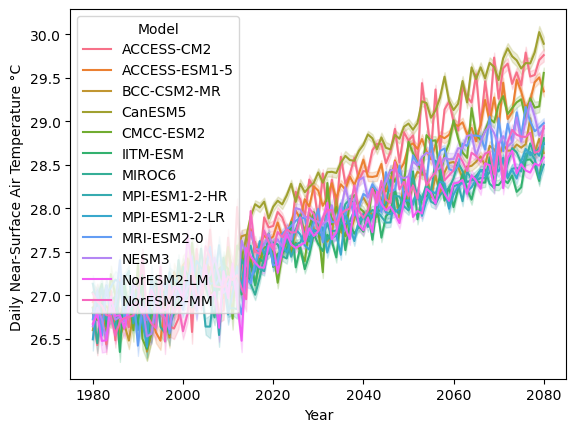

In [11]:
p=sns.lineplot(df_tas_filt,x='Year',y='Daily Near-Surface Air Temperature °C ',hue='Model')

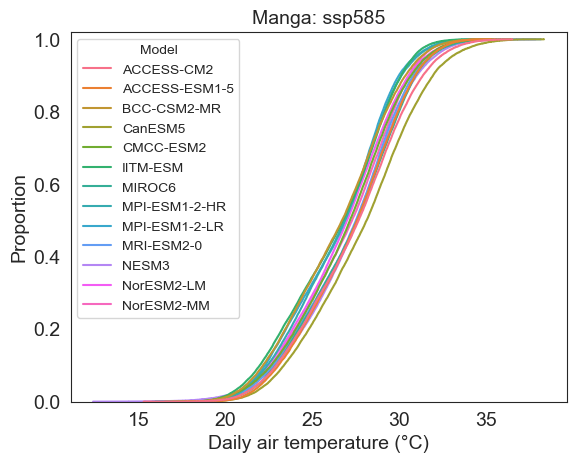

In [18]:
#USE THIS ONE
# CDF-curves for Models with different scenarios 
var='Daily mean '
scenario='ssp585' #'ssp126', ssp245', 'ssp370','ssp585' 'historical'
loc_= loc.replace('_','') # take off every - of project names historical
loc_=loc_.replace('WTP','')
loc_=loc_.replace('EIB','')

df_scen=df_tas_filt[df_tas_filt['Experiment']==scenario]

f, ax = plt.subplots()
#for m in models:
ax = sns.ecdfplot(x=df_scen['Daily Near-Surface Air Temperature °C '], hue=df_scen['Model'])
ax.grid(False)
sns.set_context( rc={"axes.titlesize":14,"axes.labelsize":14})  
ylim_min=0#df[y_axis].min()
ylim_max=1.02#df[y_axis].max()
ax.set_ylim(ylim_min,ylim_max)
ax.tick_params(labelsize=14)
plt.xlabel('Daily air temperature (°C)')
sns.set_style("white")
sns.set_style(rc = {'axes.facecolor': 'white'})
title=loc_': ' + scenario
plt.title(title)
f.tight_layout#
f.savefig(loc+'_tas_'+scenario+ '.svg', bbox_inches='tight')



## TASMAX: all days - no aggregation

In [103]:
#_____________CAHNGE INPUT ___________________________# 
loc='PanteMacassar'  # gr1: 'Beloi', 'Maliana', 'Lospalos' GR2: 'Viqueque', 'Casse', 'Vemasse'
yr_past=np.array([1984, 2014]) # set periods
yr_future=np.array([2030,2060])
mod_excl=['TaiESM1']# 'TaiESM1'
#_______________________________________________________# 

df_tasmax_filt= filter_data(df_tasmax,loc,mod_excl)#'TaiESM1','CMCC-CM2-SR5','NESM3'
#Past and future - seperated
df_tasmax_future=df_tasmax_filt.reset_index()[df_tasmax_filt.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Daily Maximum Near-Surface Air Temperature °C ','Model','Experiment']]
df_tasmax_past=df_tasmax_filt.reset_index()[df_tasmax_filt.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Daily Maximum Near-Surface Air Temperature °C ' ,'Model','Experiment']]

df_perc_future=df_tasmax_future.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
df_perc_past=df_tasmax_past.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=['ssp126', 'ssp245', 'ssp370',  'ssp585']
#scenarios=list(df_tasmax_NEXGDDPCMIP6_loc_future.Experiment.unique())
model_quant=['1%','10%','50%','90%','95%','97.5%','99%']
result=pd.DataFrame() #initialize dataframe

df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
#print(df_hist)
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
#print(df_hist)
df_hist_perc=df_hist.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
#print(df_hist_perc)
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
#print(df_hist_perc)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
df_hist_perc['Experiment']='historical'
result=pd.concat([result,df_hist_perc])
for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:].droplevel('Experiment')
    df_past=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
    diff=(df_future-df_past)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

print(result)
name='tasmax_'+loc+ '_'+ str(yr_future[0]) +str(yr_future[1]) +'_'+ str(yr_past[0]) +str(yr_past[1]) +'_.xlsx'
result.to_excel(name)  

       index         1%   p10 data   p50 data   p90 data        95%  \
5  p10 model  25.170514  26.311519  27.723627  28.890556  29.178766   
6  p50 model  25.345967  26.391644  27.760040  28.926800  29.226089   
7  p90 model  25.435842  26.481600  27.799414  29.020189  29.320950   
5  p10 model   0.215995   0.406202   0.636142   0.820007   0.881350   
6  p50 model   0.474900   0.692032   0.909378   1.110437   1.149608   
7  p90 model   1.053015   0.984172   1.103946   1.372853   1.429446   
5  p10 model   0.760903   0.758133   0.809308   0.882407   0.872063   
6  p50 model   0.863227   0.938202   1.061706   1.182196   1.189163   
7  p90 model   1.359558   1.205351   1.276904   1.437745   1.472299   
5  p10 model   0.569852   0.678564   0.881592   1.083056   1.173538   
6  p50 model   0.786160   0.841999   1.056701   1.313074   1.368674   
7  p90 model   1.026493   1.258392   1.510620   1.730700   1.770505   
5  p10 model   0.798794   0.940581   1.034619   1.142154   1.166580   
6  p50

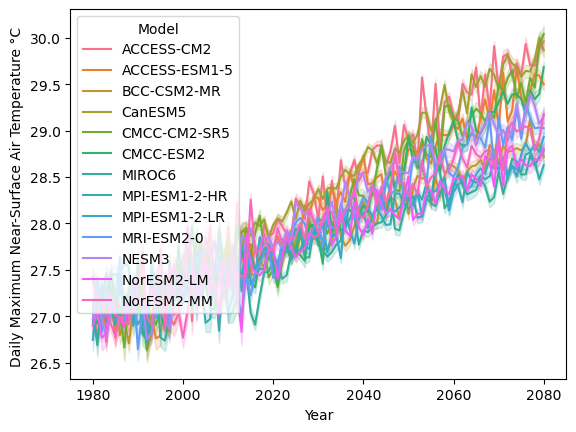

In [16]:
p=sns.lineplot(df_tasmax_filt,x='Year',y='Daily Maximum Near-Surface Air Temperature °C ',hue='Model')

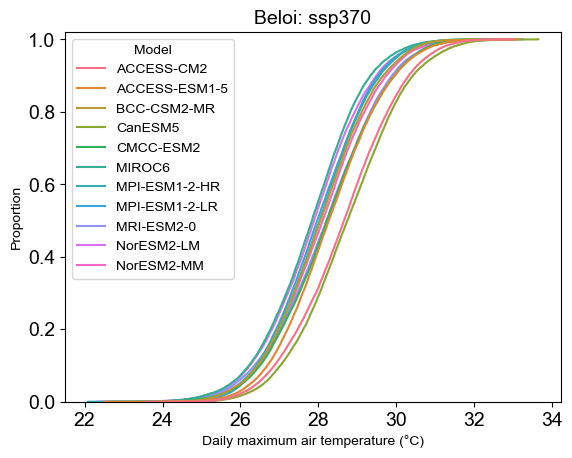

In [11]:
#USE THIS ONE
# CDF-curves for Models with different scenarios 
var='Daily max '
scenario='ssp370' #'ssp126', ssp245', 'ssp370','ssp585' 'historical'
loc_= loc.replace('_','') # take off every - of project names
loc_=loc_.replace('WTP','')
loc_=loc_.replace('EIB','')

df_tas_scen=df_tasmax_filt[df_tasmax_filt['Experiment']==scenario]

f, ax = plt.subplots()
#for m in models:
ax = sns.ecdfplot(x=df_tas_scen['Daily Maximum Near-Surface Air Temperature °C '], hue=df_tas_scen['Model'])
ax.grid(False)
sns.set_context( rc={"axes.titlesize":14,"axes.labelsize":14})  
ylim_min=0#df[y_axis].min()
ylim_max=1.02#df[y_axis].max()
ax.set_ylim(ylim_min,ylim_max)
ax.tick_params(labelsize=14)
plt.xlabel('Daily maximum air temperature (°C)')
sns.set_style("white")
sns.set_style(rc = {'axes.facecolor': 'white'})
title=loc_+ ': ' + scenario
plt.title(title)
f.tight_layout#
f.savefig(loc+'_tasmax_'+scenario+ '.svg', bbox_inches='tight')

## TASMAX: yearly aggregation on 90th percentile
#### Taxmax- yearly aggregation 90th quantiles: All models treated together  - differentiating the scenario

In [104]:
df_tasmax_yrp90_ = df_tasmax_filt.groupby(['Name project','Experiment','Model','Year']).quantile([0.9])
df_tasmax_yrp90=df_tasmax_yrp90_.reset_index()
# df_tasmax_yrp90_loc = df_tasmax_NEXGDDPCMIP6_loc.groupby(['Name project','Experiment','Model','Year']).quantile([0.9])
# df_tasmax_yrp90_loc=df_tasmax_yrp90_loc.reset_index()

#Past and future - seperated
df_tasmax_yrp90_future=df_tasmax_yrp90.reset_index()[df_tasmax_yrp90.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Daily Maximum Near-Surface Air Temperature °C ','Model','Experiment']]
df_tasmax_yrp90_past=df_tasmax_yrp90.reset_index()[df_tasmax_yrp90.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Daily Maximum Near-Surface Air Temperature °C ','Model','Experiment']]
#Finding percentiles of the maximum temperature aggregated per year 
df_perc_future=df_tasmax_yrp90_future.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
df_perc_past=df_tasmax_yrp90_past.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=['ssp126', 'ssp245', 'ssp370',  'ssp585']
model_quant=['1%','10%','50%','90%','95%','97.5%','99%']
result=pd.DataFrame() #initialize dataframe


df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
#print(df_hist)
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
#print(df_hist)
df_hist_perc=df_hist.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
#print(df_hist_perc)
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
#print(df_hist_perc)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
df_hist_perc['Experiment']='historical'
result=pd.concat([result,df_hist_perc])

for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:] 
    df_past=df_perc_past.loc[idx['historical',:],:]
  #  print(df_future)
    df_future=df_future.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')
    df_past=df_past.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')
    diff=(df_future-df_past)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
  #  print(diff)
    diff_perc=diff.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
   # print(diff_perc)
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    #print(diff_perc)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

print(result)
name=loc+'_tasmax_aggYr90.xlsx'
result.to_excel(name)  


       index         1%   p10 data   p50 data   p90 data        95%  \
5  p10 model  28.264583  28.399408  28.834020  29.126289  29.232900   
6  p50 model  28.306735  28.518512  28.903314  29.217548  29.288833   
7  p90 model  28.449834  28.603033  28.952731  29.419622  29.555793   
5  p10 model   0.543876   0.667970   0.792375   0.825612   0.922052   
6  p50 model   1.110271   1.047156   1.080854   1.204352   1.222543   
7  p90 model   1.354193   1.340097   1.328398   1.502355   1.524482   
5  p10 model   0.715581   0.786796   0.870598   0.878474   0.858513   
6  p50 model   0.982001   1.097913   1.150250   1.284195   1.263279   
7  p90 model   1.300899   1.310425   1.399272   1.555113   1.500175   
5  p10 model   0.669912   0.868854   0.913690   1.170588   1.213864   
6  p50 model   0.981054   1.162970   1.235102   1.445593   1.538852   
7  p90 model   1.405358   1.582758   1.718072   1.964447   1.976794   
5  p10 model   0.806595   0.873777   1.121938   1.249055   1.181180   
6  p50

# Mean precipitation 

In [19]:
df_pr

,Name project,Experiment,Model,Latitude,Longitude,Date,Mean of the daily precipitation rate mm/day
0,Beloi,historical,ACCESS-CM2,-8.125,125.625,01-01-1980,4.805838
1,Beloi,historical,ACCESS-CM2,-8.125,125.625,02-01-1980,10.661283
2,Beloi,historical,ACCESS-CM2,-8.125,125.625,03-01-1980,21.657160
3,Beloi,historical,ACCESS-CM2,-8.125,125.625,04-01-1980,7.030401
4,Beloi,historical,ACCESS-CM2,-8.125,125.625,05-01-1980,7.290690
...,...,...,...,...,...,...,...
4833472,Lospalos,ssp370,TaiESM1,-8.625,127.125,27-12-2080,11.983222
4833473,Lospalos,ssp370,TaiESM1,-8.625,127.125,28-12-2080,15.511542
4833474,Lospalos,ssp370,TaiESM1,-8.625,127.125,29-12-2080,3.509354
4833475,Lospalos,ssp370,TaiESM1,-8.625,127.125,30-12-2080,0.000000


In [105]:
#_____________CAHNGE INPUT ___________________________# 
loc='PanteMacassar' # gr1: 'Beloi', 'Maliana', 'Lospalos'  GR2: 'Viqueque', 'Casse', 'Vemasse'
yr_past=np.array([1984, 2014]) # set periods
yr_future=np.array([2030,2060])
mod_excl=[]# 
#_______________________________________________________# 

df_pr_filt= filter_data(df_pr,loc,mod_excl)#'TaiESM1','CMCC-CM2-SR5','NESM3'
#Past and future - seperated
df_pr_future=df_pr_filt.reset_index()[df_pr_filt.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Mean of the daily precipitation rate mm/day','Model','Experiment']]
df_pr_past=df_pr_filt.reset_index()[df_pr_filt.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Mean of the daily precipitation rate mm/day' ,'Model','Experiment']]

df_perc_future=df_pr_future.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
df_perc_past=df_pr_past.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=['ssp126', 'ssp245', 'ssp370',  'ssp585']
#scenarios=list(df_tasmax_NEXGDDPCMIP6_loc_future.Experiment.unique())
model_quant=['1%','10%','50%','90%','95%','97.5%','99%']
result=pd.DataFrame() #initialize dataframe

df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
#print(df_hist)
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
#print(df_hist)
df_hist_perc=df_hist.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
#print(df_hist_perc)
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
#print(df_hist_perc)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
df_hist_perc['Experiment']='historical'
result=pd.concat([result,df_hist_perc])
for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:].droplevel('Experiment')
    df_past=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
    diff=(df_future-df_past)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

print(result)
name='meanPrec_'+loc+ '_'+ str(yr_future[0]) +str(yr_future[1]) +'_'+ str(yr_past[0]) +str(yr_past[1]) +'_.xlsx'
result.to_excel(name)  

       index   1%  p10 data  p50 data   p90 data        95%      97.5%  \
5  p10 model  0.0       0.0  0.115002  11.006832  15.308156  19.180992   
6  p50 model  0.0       0.0  0.401822  11.732259  16.117537  20.105400   
7  p90 model  0.0       0.0  0.577477  12.331385  16.857193  21.330797   
5  p10 model  0.0       0.0 -0.220103  -0.833728  -0.750788  -0.126912   
6  p50 model  0.0       0.0 -0.088902  -0.180828  -0.068803   0.321567   
7  p90 model  0.0       0.0  0.094856   0.216996   0.284686   0.977470   
5  p10 model  0.0       0.0 -0.188822  -0.980110  -0.700111  -0.947300   
6  p50 model  0.0       0.0 -0.120994  -0.187805  -0.141608   0.006540   
7  p90 model  0.0       0.0  0.081539   0.458539   0.445054   1.484143   
5  p10 model  0.0       0.0 -0.158605  -0.615584  -0.740344  -0.657998   
6  p50 model  0.0       0.0 -0.075540  -0.275650   0.006599   0.231096   
7  p90 model  0.0       0.0  0.078371   0.560953   0.625301   1.129630   
5  p10 model  0.0       0.0 -0.205746 

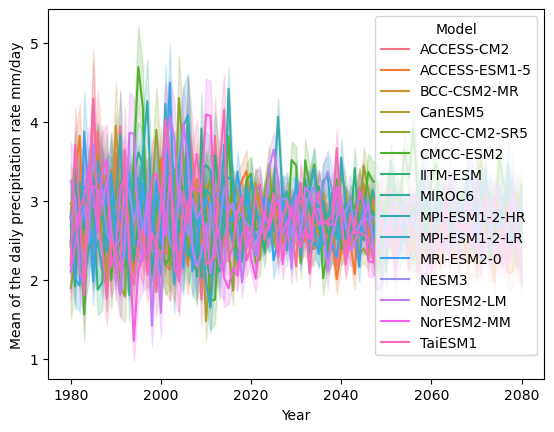

In [21]:
p=sns.lineplot(df_pr_filt,x='Year',y='Mean of the daily precipitation rate mm/day',hue='Model')

# Precipitation ; days above threshold 

In [108]:
#df_pr['Name project'].unique()

# ___________CHANGE ACCORDING TO PURPOSE ________________________________# 

loc='PanteMacassar'#   gr1: 'Beloi', 'Maliana', 'Lospalos' # GR2: 'Viqueque', 'Casse', 'Vemasse'
mod_excl=[]#'NESM3','CMCC-CM2-SR5','TaiESM1'
yr_past=np.array([1984, 2014])
yr_future=np.array([2030,2060])
threshold_val= 20 #threshold value to count days above 

#______________________________________________________________# 

df_pr=pd.read_csv(path_pr)
df_pr_filt=filter_data(df_pr,loc,mod_excl)
df_pr_yrThreshold = df_pr_filt[df_pr_filt['Mean of the daily precipitation rate mm/day']>threshold_val].groupby(['Name project','Experiment','Model','Year']).count()
df_pr_yrThreshold_future=df_pr_yrThreshold.reset_index()[df_pr_yrThreshold.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Mean of the daily precipitation rate mm/day','Model','Experiment']]
df_pr_yrThreshold_past=df_pr_yrThreshold.reset_index()[df_pr_yrThreshold.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Mean of the daily precipitation rate mm/day','Model','Experiment']]
#df_pr_yrThreshold_past['Mean of the daily precipitation rate mm_per_day'].mean()

#Finding percentiles 
df_perc_future=df_pr_yrThreshold_future.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
df_perc_past=df_pr_yrThreshold_past.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=['ssp126', 'ssp245', 'ssp370', 'ssp585']
model_quant=['1%','10%','50%','90%','95%','97.5%','99%']
result=pd.DataFrame() #initialize dataframe
df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
df_hist_perc=df_hist.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
df_hist_perc['Experiment']='historical'
result=pd.concat([result,df_hist_perc])

for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:]
   # print(df_future)
    df_past=df_perc_past.loc[idx['historical',:],:]
   # print(df_past)
    df_future=df_future.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')
    df_past=df_past.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')
    diff=(df_future-df_past)
   # print(diff)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

print(result)
name='pr_above_'+str(threshold_val)+loc+'_'+ str(yr_future[0]) +str(yr_future[1]) +'_'+ str(yr_past[0]) +str(yr_past[1]) +'_.xlsx'
result.to_excel(name)  


       index    1%  p10 data  p50 data  p90 data    95%   97.5%     99%  \
5  p10 model  1.30       3.0       7.0      11.8  12.30  13.150  13.780   
6  p50 model  3.00       5.0       9.0      15.0  16.50  18.250  18.700   
7  p90 model  4.72       6.6      11.6      16.0  17.80  19.800  20.460   
5  p10 model -1.54      -1.0      -1.0      -0.6  -0.50  -1.000  -1.620   
6  p50 model -0.10       0.0       1.0       1.0   1.05   0.750   2.900   
7  p90 model  1.72       1.0       1.0       2.0   3.00   5.250   7.120   
5  p10 model -1.70      -2.0      -1.0      -3.2  -2.90  -3.150  -3.600   
6  p50 model  0.00       0.0       0.0       0.0   0.00   0.750   2.100   
7  p90 model  0.18       2.2       2.0       4.6   5.10   5.500   6.520   
5  p10 model -0.98      -1.7      -1.0      -1.7  -2.50  -3.600  -4.140   
6  p50 model  0.15       0.0       0.0       1.0   1.50   1.625   2.500   
7  p90 model  1.40       2.7       1.0       4.4   6.45   6.275   6.929   
5  p10 model -1.78      -

In [ ]:
# p=sns.lineplot(df_pr_filt,x='Year',y='Mean of the daily precipitation rate mm_per_day',hue='Model')

In [ ]:
#USE THIS ONE
# CDF-curves for Models with different scenarios 
#var='20 mm '
scenario='ssp585' #'ssp126', ssp245', 'ssp370','ssp585' 'historical'
loc_= loc.replace('_','') # take off every - of project names
loc_=loc_.replace('WTP','')
loc_=loc_.replace('EIB','')

df_tas_scen=df_pr_yrThreshold_future[df_pr_yrThreshold_future['Experiment']==scenario]
#df_tas_scen=df_pr_yrThreshold_future[df_pr_yrThreshold_future['Experiment']==scenario]
f, ax = plt.subplots()
#for m in models:
ax = sns.ecdfplot(x=df_tas_scen['Mean of the daily precipitation rate mm_per_day'], hue=df_tas_scen['Model'])
ax.grid(False)
sns.set_context( rc={"axes.titlesize":14,"axes.labelsize":14})  
ylim_min=0#df[y_axis].min()
ylim_max=1.02#df[y_axis].max()
ax.set_ylim(ylim_min,ylim_max)
ax.tick_params(labelsize=14)
plt.xlabel('Days per year with daily precipitation rate above'+' '+ var)
sns.set_style("white")
sns.set_style(rc = {'axes.facecolor': 'white'})
title=loc_+ ': ' + scenario
plt.title(title)
f.tight_layout#
f.savefig(loc +'pr_above'+str(threshold_val)+ scenario+'.svg', bbox_inches='tight')

# Net precipitation per month

In [13]:
#path_PET=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\calculate_PET\netPrec_future\df_ET0_FAOequation_Mutua_albedo.csv'
path_ET0=r'C:\Users\nadb\OneDrive - COWI\Documents\GitHub\CRVA_tool\df_ET0_FAOequation_Mutua_albedo.csv'
# path_pr=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\pr\pr_mm_per_day_day_1950-2100\pr_1950-2100_projectsMoz.csv'
#tas: daily mean temperature
loc='WTP_Mutua_EIB'
yr_past=np.array([1984, 2014]) # set periods
yr_future=np.array([2030,2060])
mod_excl=['CMCC-CM2-SR5','TaiESM1']



#READ ET0
df_ET0=pd.read_csv(path_ET0)
df_ET0=filter_data(df_ET0,loc,mod_excl)
df_ET0_past=df_ET0[df_ET0['Year'].between(yr_past[0],yr_past[1])]
df_ET0_future=df_ET0[df_ET0['Year'].between(yr_future[0],yr_future[1])]

#READ PRECIPITATION 
#df_pr=pd.read_csv(path_pr)
df_pr_filt=filter_data(df_pr,loc,mod_excl)
df_pr_past=df_pr_filt[df_pr_filt['Year'].between(yr_past[0],yr_past[1])]
df_pr_future=df_pr_filt[df_pr_filt['Year'].between(yr_future[0],yr_future[1])]

df_netPr = df_ET0.copy(deep=True)
df_netPr.rename(columns={'ET0 mm':'Net precipitation mm'},inplace=True)
df_netPr=df_netPr.set_index(['Experiment','Model','Date'])
ET0=df_ET0.reset_index().set_index(['Experiment','Model','Date'])
pr=df_pr_filt.reset_index().set_index(['Experiment','Model','Date']) 
pr['Mean of the daily precipitation rate mm_per_day']-ET0['ET0 mm']  
df_netPr['Net precipitation mm']=pr['Mean of the daily precipitation rate mm_per_day']-ET0['ET0 mm']
df_netPr=df_netPr.reset_index()
df_netPr

df_netPr_future=df_netPr.reset_index()[df_netPr.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Net precipitation mm','Model','Experiment','Year','Month']]
df_netPr_past=df_netPr.reset_index()[df_netPr.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Net precipitation mm','Model','Experiment','Year','Month']]

#here something happens with the zeros. 


Net precipitation mm
Name project  Experiment Model      Year Month                      
WTP_Mutua_EIB ssp126     ACCESS-CM2 2030 Apr              189.643876
                                         Aug             -104.511004
                                         Dec             -127.794005
                                         Feb               26.869363
                                         Jan               25.826931
...                                                              ...
              ssp585     NorESM2-MM 2060 Mar               58.268995
                                         May             -107.822475
                                         Nov             -180.202019
                                         Oct             -216.753714
                                         Sep             -161.262613

[19344 rows x 1 columns]

In [163]:
# df_netPr_month_1 = df_netPr.groupby(['Name project','Experiment','Model','Year','Month']).sum() 

# # df_netPr_pos_future=df_netPr_pos.reset_index()[df_netPr_pos.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Net precipitation mm','Model','Experiment']]
# # df_netPr_pos_past=df_netPr_pos.reset_index()[df_netPr_pos.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Net precipitation mm','Model','Experiment']]
# df_netPr_month_2 =df_netPr_month.groupby(['Name project','Experiment','Model','Month']).mean() 
# df_netPr_month_1

df_netPr_past_month=df_netPr_past.groupby(['Name project','Experiment','Year','Model','Month']).mean()*(365/12) #mean dage per måned for hvert år
#df_netPr_past_months =df_netPr_past_month.groupby(['Name project','Experiment','Month']).mean() # mean per måned for alle år
df_netPr_future_month=df_netPr_future.groupby(['Name project','Experiment','Year','Model','Month']).mean()*(365/12)
#df_netPr_future_months =df_netPr_future_month.groupby(['Name project','Experiment','Month']).mean() 

df_future_std=df_netPr_future_month.groupby(['Experiment','Month','Year']).std() # checks standard deviation 
df_past_std=df_netPr_past_month.groupby(['Experiment','Month','Year']).std() # checks standard deviation
#df_netPr_past_test=df_netPr_past_month.groupby(['Experiment','Model','Month']).describe(percentiles=[.1,.5,.9])
df_netPr_future_test=df_netPr_future_month.groupby(['Experiment','Model','Month']).describe(percentiles=[.1,.5,.9])
df_netPr_future_test.to_excel('future_test.xlsx')

In [142]:
#Finding percentiles of positive netprecipitation aggregated per year 
df_perc_future=df_netPr_future_month.groupby(['Experiment','Month']).describe(percentiles=[.1,.5,.9]) #
df_perc_past=df_netPr_past_month.groupby(['Experiment','Month']).describe(percentiles=[.1,.5,.9])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=['ssp126', 'ssp245', 'ssp370',  'ssp585']#'ssp370',
model_quant=['10%','50%','90%']
result=pd.DataFrame() #initialize dataframe

df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
#print(df_hist)
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
#print("DIFF_HIST=",df_hist)

# df_hist_perc=df_hist.describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99])
# print(df_hist_perc)
# dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
# df_hist_perc.rename(index=dict,inplace=True)
#print(df_hist_perc)
# df_hist_perc=df_hist_perc.reset_index()
# df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
#df_hist=df_hist.reset_index()
df_hist['Experiment']='historical'
result=pd.concat([result,df_hist])
#print(result)

for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:]
    df_past=df_perc_past.loc[idx['historical',:],:]
    df_future=df_future.reset_index().set_index(['Experiment','Month']).droplevel('Experiment')
    print(df_future)
    df_past=df_past.reset_index().set_index(['Experiment','Month']).droplevel('Experiment')   
#     print(df_past)
    diff=(df_future-df_past) 
   #
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
#     diff_perc=diff.describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99])  
#     dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
#     diff_perc.rename(index=dict,inplace=True)
#     diff_perc=diff_perc.reset_index()
#     diff=diff[diff['index'].isin(['p10 model','p50 model','p90 model'])]
    diff['Experiment']=s
    result=pd.concat([result,diff],axis=0)
result=result.transpose()
name='netPr_months'+loc+ '_'+ str(yr_future[0]) +str(yr_future[1]) +'_'+ str(yr_past[0]) +str(yr_past[1]) +'_.xlsx'
result.to_excel(name)  


      Net precipitation mm                                                  \
                     count        mean         std         min         10%   
Month                                                                        
Apr                  310.0  -39.931439   77.786879 -151.372801 -119.468184   
Aug                  310.0 -107.049692   28.483252 -160.604848 -138.773181   
Dec                  310.0   31.119438  125.275770 -209.738262 -125.971199   
Feb                  310.0   87.447906  122.451428 -145.628627  -54.620190   
Jan                  310.0   76.896815  119.358855 -188.523173  -74.786357   
Jul                  310.0  -79.132463   26.956275 -147.253269 -109.034966   
Jun                  310.0  -68.885165   34.047221 -134.145778 -104.646077   
Mar                  310.0   61.369506  130.691856 -177.517790  -84.688106   
May                  310.0  -64.973896   41.894137 -133.354511 -109.019769   
Nov                  310.0 -129.877373   68.919845 -251.289180 -

# Net precipitation: positive per year

In [6]:
## ________________________CHANGE INPUT ___________________________________________________
#path_PET=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\calculate_PET\netPrec_future\df_ET0_FAOequation_Mutua_albedo.csv'
path_ET0=r'C:\Users\nadb\OneDrive - COWI\Documents\GitHub\CRVA_tool\df_ET0_FAOequation_Mutua_albedo.csv'
#path_pr=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\pr\pr_mm_per_day_day_1950-2100\pr_1950-2100_projectsMoz.csv'
#tas: daily mean temperature
loc='Cassa'
yr_past=np.array([1984, 2014]) # set periods
yr_future=np.array([2030,2060])
mod_excl=[]
#__________________________________________________________________# 


#READ ET0
df_ET0=pd.read_csv(path_ET0)
df_ET0=filter_data(df_ET0,loc,mod_excl)
df_ET0_past=df_ET0[df_ET0['Year'].between(yr_past[0],yr_past[1])]
df_ET0_future=df_ET0[df_ET0['Year'].between(yr_future[0],yr_future[1])]

#READ PRECIPITATION 
#df_pr=pd.read_csv(path_pr)
df_pr_filt=filter_data(df_pr,loc,mod_excl)
df_pr_past=df_pr_filt[df_pr_filt['Year'].between(yr_past[0],yr_past[1])]
df_pr_future=df_pr_filt[df_pr_filt['Year'].between(yr_future[0],yr_future[1])]


#READ netPrecipitation  
# df_netPr=pd.read_csv(path_netPr)
# df_netPr=filter_data(df_netPr,loc,mod_excl)
# df_netPr_past=df_netPr[df_netPr['Year'].between(yr_past[0],yr_past[1])]
# df_netPr_future=df_netPr[df_netPr['Year'].between(yr_future[0],yr_future[1])]


df_netPr = df_ET0.copy(deep=True)
df_netPr.rename(columns={'ET0 mm':'Net precipitation mm'},inplace=True)
df_netPr=df_netPr.set_index(['Experiment','Model','Date'])
ET0=df_ET0.reset_index().set_index(['Experiment','Model','Date'])
pr=df_pr_filt.reset_index().set_index(['Experiment','Model','Date']) 
pr['Mean of the daily precipitation rate mm_per_day']-ET0['ET0 mm']  
df_netPr['Net precipitation mm']=pr['Mean of the daily precipitation rate mm_per_day']-ET0['ET0 mm']
df_netPr=df_netPr.reset_index()
df_netPr


#yearly aggregation of days with positive netPrecipitaiton 
df_netPr_pos = df_netPr[df_netPr['Net precipitation mm']>0].groupby(['Name project','Experiment','Model','Year']).count()
df_netPr_pos_future=df_netPr_pos.reset_index()[df_netPr_pos.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Net precipitation mm','Model','Experiment']]
df_netPr_pos_past=df_netPr_pos.reset_index()[df_netPr_pos.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Net precipitation mm','Model','Experiment']]

#Finding percentiles of positive netprecipitation aggregated per year 
df_perc_future=df_netPr_pos_future.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99]) #
df_perc_past=df_netPr_pos_past.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=['ssp126', 'ssp245', 'ssp370',  'ssp585']#'ssp370',
model_quant=['1%','10%','50%','90%','95%','97.5%','99%']
result=pd.DataFrame() #initialize dataframe

df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
#print(df_hist)
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
#print(df_hist)
df_hist_perc=df_hist.describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99])
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
#print(df_hist_perc)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
df_hist_perc['Experiment']='historical'
result=pd.concat([result,df_hist_perc])

for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:]
    df_past=df_perc_past.loc[idx['historical',:],:]
    df_future=df_future.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')
    df_past=df_past.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')   
    diff=(df_future-df_past) #this doesnt work 
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[0.01,.1,.5,.9,.95,.975,.99])  
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

name='netPr_pos_'+loc+ '_'+ str(yr_future[0]) +str(yr_future[1]) +'_'+ str(yr_past[0]) +str(yr_past[1]) +'_.xlsx'
result.to_excel(name)  
print(result)


IndexError: index 1 is out of bounds for axis 0 with size 0

In [ ]:
p=sns.lineplot(df_netPr,x='Year',y='Net precipitation mm',hue='Model')

# Precipitation: consecutive days above 5mm 


In [107]:
# CHANGE ACCORDING TO PURPOSE 
loc='PanteMacassar' # gr1: 'Beloi', 'Maliana', 'Lospalos'  GR2: 'Viqueque', 'Casse', 'Vemasse'
mod_excl=[]#'NESM3','CMCC-CM2-SR5','TaiESM1'
yr_past=np.array([1984, 2014])
yr_future=np.array([2030,2060])


def filter_data(df,loc,mod_excl): # Filter data by location, models, and time period
    df = df[df['Name project']==loc]
    df = df[~df['Model'].isin(mod_excl)]
    df=add_year_month_season(df,'Date')
    return df

#precipitation 
df_pr_filt=filter_data(df_pr,loc,mod_excl)
df_pr_past=df_pr_filt[df_pr_filt['Year'].between(yr_past[0],yr_past[1])]
df_pr_future=df_pr_filt[df_pr_filt['Year'].between(yr_future[0],yr_future[1])]

def consecutive_rain(prec_data):
    
    K, N , res , prev = 5,5 ,0 ,1
    strt, end = 0, 0
    for idx, ele in enumerate(prec_data):
        if ele >= K:
            end = idx
            if prev < K: # previous item one
                strt = idx
        else:
            if prev >= K and end - strt + 1 >= N:
                res=res+1
        if idx == (len(prec_data)-1): # if the last element is not greater 
            if ele>=K:
                if prev >= K and end - strt + 1 >= N:                
                    res=res+1    
        prev = ele
    return(res)

df_pr_cons=df_pr_filt.groupby(['Experiment','Model','Year'])['Mean of the daily precipitation rate mm/day'].apply(consecutive_rain)

df_pr_cons.reset_index()
df_pr_cons_future=df_pr_cons.reset_index()[df_pr_cons.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Model','Experiment','Mean of the daily precipitation rate mm/day']]
df_pr_cons_past=df_pr_cons.reset_index()[df_pr_cons.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Model','Experiment','Mean of the daily precipitation rate mm/day']]

#Finding percentiles of the maximum temperature aggregated per year 
df_perc_future=df_pr_cons_future.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
df_perc_past=df_pr_cons_past.groupby(['Experiment','Model']).describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=['ssp126', 'ssp245', 'ssp370', 'ssp585']
model_quant=['1%','10%','50%','90%','95%','97.5%','99%']
result=pd.DataFrame() #initialize dataframe
df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
df_hist_perc=df_hist.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
df_hist_perc['Experiment']='historical'
result=pd.concat([result,df_hist_perc])

for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:]
    #print('df_future:',df_future)
    df_past=df_perc_past.loc[idx['historical',:],:]
    #print(df_past)
    df_future=df_future.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')
    df_past=df_past.reset_index().set_index(['Experiment','Model']).droplevel('Experiment')
    diff=(df_future-df_past)
  #  print(diff)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[0.01,.1, .5, .9,.95,.975,.99])
   # print(diff_perc)
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

print(result)
name=loc +'pr_cons_5d,5mm'+'_.xlsx'
result.to_excel(name)  


       index    1%  p10 data  p50 data  p90 data   95%   97.5%    99%  \
5  p10 model  2.00       3.0       4.4       7.0  7.70   8.350   8.82   
6  p50 model  2.30       4.0       6.0       8.0  9.00   9.250   9.70   
7  p90 model  3.48       5.0       7.0       9.0  9.80  10.150  11.18   
5  p10 model -0.70      -1.0      -1.0      -1.6 -1.30  -1.550  -1.88   
6  p50 model -0.30      -1.0       0.0      -1.0 -0.50  -0.500  -1.00   
7  p90 model  0.58       0.0       0.6       1.0  1.50   2.300   3.06   
5  p10 model -0.88      -1.0      -1.0      -1.0 -1.00  -1.550  -1.76   
6  p50 model  0.00       0.0       0.0       0.0  0.00   0.000   0.00   
7  p90 model  0.36       0.0       1.0       1.0  1.00   1.350   1.30   
5  p10 model -0.88      -1.0      -1.0      -1.0 -1.35  -1.525  -1.24   
6  p50 model -0.15       0.0       0.0       0.0 -0.25  -0.125  -0.50   
7  p90 model  0.91       0.0       1.0       0.0  1.00   0.600   0.86   
5  p10 model -1.06      -1.0      -1.0      -1.6 -1

In [52]:
Year[1]

NameError: name 'Year' is not defined